## Here we look at the best model : Decision Tree with Monthly Data
## But to do that we need to figure out: 
## How much data is sufficient to reach a conclusion on model perforamance


In [1]:
# First to import relevant libraries and modules that will be used 
import numpy as np 
import pandas as pd
import random
from random import sample

#For visualization 
import matplotlib.pyplot as plt  
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

#For statistics
import math
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 

# The different algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier 

# Import the slearn utility to compare algorithms
from sklearn import model_selection,discriminant_analysis
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV



## Data Size VS Model Performance

### 1. Importing Data

In [2]:
#Importing response files 
response_data = pd.read_csv('Retail_Data_Response.csv')
response_data['response'].value_counts()
#imbalanced dataset 0-6237 and 1-647

0    6237
1     647
Name: response, dtype: int64

In [3]:
# Monthly Data
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')

# Organising data 
mth_rolling_features1 = mth_rolling_features.drop(['Unnamed: 0'], axis = 1)
mth_day_counts = mth_day_counts.sort_values(by = ['CLNT_NO','ME_DT'])
mth_day_counts1 = mth_day_counts.drop(['Unnamed: 0'], axis = 1)
days_since_last_txn1 = days_since_last_txn.drop(['Unnamed: 0'], axis =1)

# Changing column name in response data to make merging easy 
response_data1 = response_data.rename(columns = {'customer_id':'CLNT_NO'})

monthly_features_outputs = mth_rolling_features1.merge(mth_day_counts1)
monthly_features_outputs = monthly_features_outputs.merge(days_since_last_txn1)
monthly_features_outputs = monthly_features_outputs.merge(response_data1)
monthly_features_outputs = monthly_features_outputs.fillna(0)
monthly_features_outputs


,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,0,100,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845995,CS5111,2015-03-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,82,1
845996,CS5111,2015-03-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,82,1
845997,CS5111,2015-03-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,82,1
845998,CS5111,2015-03-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,82,1


In [4]:
# Separating X and y values, Monthly data
y_monthly = monthly_features_outputs['response'].values

# Dropping strings i.e Client No and Dates and response
X_monthly = monthly_features_outputs.drop(['response','ME_DT','CLNT_NO'], axis = 1).values

# Monthly train test data 
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size= 1/10, random_state=1147)

# Making them into dataframes to easily manage them 
X_train_monthly = pd.DataFrame(X_train_monthly, columns =monthly_features_outputs.columns[2:30])
X_test_monthly = pd.DataFrame(X_test_monthly, columns = monthly_features_outputs.columns[2:30] )
y_train_monthly = pd.DataFrame(y_train_monthly, columns = ['response'])
y_test_monthly  = pd.DataFrame(y_test_monthly, columns = ['response'] )


In [5]:

# Further improvement of model by increasing parameters 
param_grid = [ {'max_depth': range(1,20), 'min_samples_split' : [2,3,4,5,6,7,8,9,10] }]

decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error')

grid_search.fit(X_train_monthly,y_train_monthly)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': range(1, 20),
                          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}],
             scoring='neg_mean_squared_error')

In [ ]:
#GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
   #          param_grid=[{'max_depth': range(1, 20),
    #                      'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}],
   #          scoring='neg_mean_squared_error')

In [6]:
# Best parameters
decision_tree = DecisionTreeClassifier()
print('Therefore the parameters we will use are:',grid_search.best_params_)
# Therefore the parameters we will use are: {'max_depth': 19, 'min_samples_split': 2}


Therefore the parameters we will use are: {'max_depth': 19, 'min_samples_split': 2}


In [29]:
#!pip install imblearn

In [7]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler()
X_res, y_res = under_sampler.fit_resample(X_train_monthly, y_train_monthly)


### 2. Sample Size VS Test AUC

#### N samples = 50 


In [8]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 50
auc_test = []
sample_number = []

for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_50 = pd.DataFrame(table_results)
print('\n')
print('N = 50 Samples')
table_50




N = 50 Samples


,Sample #,Test AUC
0,1,0.497465
1,2,0.511251
2,3,0.521665
3,4,0.513175
4,5,0.509724
5,6,0.505297
6,7,0.508962
7,8,0.505975
8,9,0.510564
9,10,0.511610


#### N samples = 100

In [9]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 100
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_100 = pd.DataFrame(table_results)
print('\n')
print('N = 100 Samples')
table_100




N = 100 Samples


,Sample #,Test AUC
0,1,0.509086
1,2,0.500137
2,3,0.513384
3,4,0.526125
4,5,0.513632
5,6,0.504375
6,7,0.501137
7,8,0.509476
8,9,0.514757
9,10,0.486119


#### N samples = 500

In [10]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 500
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_500 = pd.DataFrame(table_results)
print('\n')
print('N = 500 Samples')
table_500




N = 500 Samples


,Sample #,Test AUC
0,1,0.522000
1,2,0.506394
2,3,0.509057
3,4,0.518405
4,5,0.512708
5,6,0.515510
6,7,0.502054
7,8,0.513639
8,9,0.509001
9,10,0.520349


#### N samples = 1000

In [11]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 1000
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_1000 = pd.DataFrame(table_results)
print('\n')
print('N = 1000 Samples')
table_1000




N = 1000 Samples


,Sample #,Test AUC
0,1,0.508182
1,2,0.520126
2,3,0.504523
3,4,0.524350
4,5,0.520366
5,6,0.510564
6,7,0.522334
7,8,0.522946
8,9,0.527559
9,10,0.519864


#### N samples = 2000

In [12]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 2000
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_2000 = pd.DataFrame(table_results)
print('\n')
print('N = 2000 Samples')
table_2000




N = 2000 Samples


,Sample #,Test AUC
0,1,0.534062
1,2,0.536685
2,3,0.514696
3,4,0.516597
4,5,0.524593
5,6,0.516125
6,7,0.537150
7,8,0.523400
8,9,0.525300
9,10,0.529514


#### N samples = 5000

In [13]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 5000
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_5000 = pd.DataFrame(table_results)
print('\n')
print('N = 5000 Samples')
table_5000




N = 5000 Samples


,Sample #,Test AUC
0,1,0.533472
1,2,0.539369
2,3,0.537043
3,4,0.536118
4,5,0.532788
5,6,0.526771
6,7,0.527516
7,8,0.530011
8,9,0.535972
9,10,0.526886


#### N samples = 10 000

In [14]:
X_test = X_test_monthly
y_test = y_test_monthly

Xy_train = pd.DataFrame(X_res,columns = X_train_monthly.columns)
Xy_train['response'] = y_res

n_samples = 10000
auc_test = []
sample_number = []


for i in range(1,11):

    Xy_train_n = Xy_train.sample(n = n_samples)

    # Fitting model
    estimator = DecisionTreeClassifier(random_state = 0, max_depth = 6, min_samples_split = 4)
    dtc_best_model = estimator.fit(Xy_train_n.iloc[:,:-1],Xy_train_n.iloc[:,-1] )
    scores_test  = dtc_best_model.predict_proba(X_test)[:,1]  

    # Predict the class of test set
    y_test_predicted = dtc_best_model.predict(X_test)
                                         
                                        
    # ROC & AUC Calc 
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_test.append(auc(fpr_test, tpr_test))
    sample_number.append(i)


table_results = {'Sample #': sample_number, 'Test AUC': auc_test}
table_10000 = pd.DataFrame(table_results)
print('\n')
print('N = 10000 Samples')
table_10000




N = 10000 Samples


,Sample #,Test AUC
0,1,0.552169
1,2,0.542923
2,3,0.546918
3,4,0.550335
4,5,0.547848
5,6,0.546049
6,7,0.551277
7,8,0.546892
8,9,0.548500
9,10,0.545594


### 3. Summary of Results

In [15]:
data_size_vs_performance = pd.DataFrame()
data_size_vs_performance['Sample size N'] = [50,100, 500, 1000, 2000, 5000, 10000]
data_size_vs_performance['Test AUC Mean'] = [table_50['Test AUC'].mean(),table_100['Test AUC'].mean(),table_500['Test AUC'].mean(),table_1000['Test AUC'].mean(),table_2000['Test AUC'].mean(),table_5000['Test AUC'].mean(),table_10000['Test AUC'].mean()]
data_size_vs_performance['Test AUC Standard Deviation'] = [table_50['Test AUC'].std(),table_100['Test AUC'].std(),table_500['Test AUC'].std(),table_1000['Test AUC'].std(),table_2000['Test AUC'].std(),table_5000['Test AUC'].std(),table_10000['Test AUC'].std()]
data_size_vs_performance


,Sample size N,Test AUC Mean,Test AUC Standard Deviation
0,50,0.509569,0.006195
1,100,0.507823,0.010743
2,500,0.512912,0.006377
3,1000,0.518081,0.007614
4,2000,0.525812,0.008422
5,5000,0.532594,0.004586
6,10000,0.547850,0.002816


### 4. Errorbar Plot

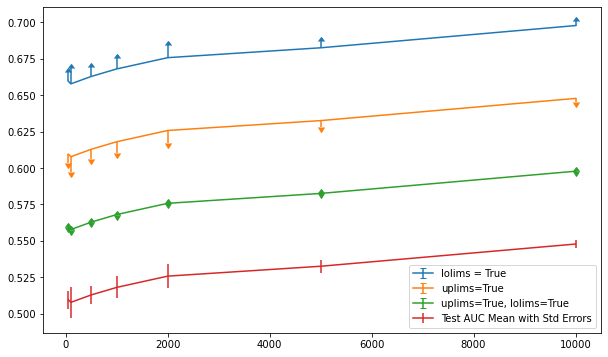

In [16]:

fig = plt.figure(figsize = (10,6))
x = data_size_vs_performance['Sample size N']
y = data_size_vs_performance['Test AUC Mean']
err =data_size_vs_performance['Test AUC Standard Deviation']


plt.errorbar(x, y + 0.15, yerr=err, lolims = True, label='lolims = True')

plt.errorbar(x, y + 0.1, yerr=err, uplims=True, label='uplims=True')

plt.errorbar(x, y + 0.05, yerr=err, uplims=True, lolims=True,
             label='uplims=True, lolims=True')

upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5
plt.errorbar(x, y, yerr = err, label = 'Test AUC Mean with Std Errors')

plt.legend(loc='lower right')

#### Note: As the sample size increases, the Mean Test AUC increases and the            standard deviation decreases, therefore the higher the sample size the better.
#### The minimum number of samples required for the model to behave adequately is approximately 2000 as the mean stops sharply increasing but decreases at a slow rate, even when compared to 10 000 samples the difference is only ~0.2. 